# [Sentence-BERT](https://arxiv.org/pdf/1908.10084.pdf)

[Reference Code](https://www.pinecone.io/learn/series/nlp/train-sentence-transformers-softmax/)

In this notebook, we implement Sentence-BERT (SBERT) using the BERT model we trained from scratch in Task 1.
Instead of using a pretrained `bert-base-uncased`, we load our own BERT weights and fine-tune them
with a siamese network structure on the NLI classification objective (SoftmaxLoss).

**Dataset credit:**
- SNLI: https://huggingface.co/datasets/snli (Bowman et al., 2015)
- MNLI: https://huggingface.co/datasets/glue/viewer/mnli (Williams et al., 2018)

**Paper:** Reimers & Gurevych, "Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks", EMNLP 2019.

In [1]:
import os
import math
import re
from   random import *
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Set GPU device
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

os.environ['http_proxy']  = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 1. Data

### Train, Test, Validation

In [2]:
import datasets
snli = datasets.load_dataset('snli')
mnli = datasets.load_dataset('glue', 'mnli')
mnli['train'].features, snli['train'].features

({'premise': Value(dtype='string', id=None),
  'hypothesis': Value(dtype='string', id=None),
  'label': ClassLabel(names=['entailment', 'neutral', 'contradiction'], id=None),
  'idx': Value(dtype='int32', id=None)},
 {'premise': Value(dtype='string', id=None),
  'hypothesis': Value(dtype='string', id=None),
  'label': ClassLabel(names=['entailment', 'neutral', 'contradiction'], id=None)})

In [3]:
# List of datasets to remove 'idx' column from
mnli.column_names.keys()

dict_keys(['train', 'validation_matched', 'validation_mismatched', 'test_matched', 'test_mismatched'])

In [4]:
# Remove 'idx' column from each dataset
for column_names in mnli.column_names.keys():
    mnli[column_names] = mnli[column_names].remove_columns('idx')

In [5]:
mnli.column_names.keys()

dict_keys(['train', 'validation_matched', 'validation_mismatched', 'test_matched', 'test_mismatched'])

In [6]:
import numpy as np
np.unique(mnli['train']['label']), np.unique(snli['train']['label'])
#snli also have -1

(array([0, 1, 2]), array([-1,  0,  1,  2]))

In [7]:
# there are -1 values in the label feature, these are where no class could be decided so we remove
snli = snli.filter(
    lambda x: 0 if x['label'] == -1 else 1
)

In [8]:
import numpy as np
np.unique(mnli['train']['label']), np.unique(snli['train']['label'])
#snli also have -1

(array([0, 1, 2]), array([0, 1, 2]))

In [9]:
# Assuming you have your two DatasetDict objects named snli and mnli
from datasets import DatasetDict
# Merge the two DatasetDict objects
raw_dataset = DatasetDict({
    'train': datasets.concatenate_datasets([snli['train'], mnli['train']]).shuffle(seed=55).select(list(range(1000))),
    'test': datasets.concatenate_datasets([snli['test'], mnli['test_mismatched']]).shuffle(seed=55).select(list(range(100))),
    'validation': datasets.concatenate_datasets([snli['validation'], mnli['validation_mismatched']]).shuffle(seed=55).select(list(range(1000)))
})
#remove .select(list(range(1000))) in order to use full dataset
# Now, merged_dataset_dict contains the combined datasets from snli and mnli
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 100
    })
    validation: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 1000
    })
})

## 2. Preprocessing

In [10]:
# Load vocab saved from Task 1 (word2id.json)
# Rebuilding from set() gives DIFFERENT ordering each run,
# so we must load the exact same mapping used during training.
import json

with open('word2id.json', 'r') as f:
    word2id = json.load(f)

id2word = {int(v): k for k, v in word2id.items()}
vocab_size = len(word2id)
print(f"Loaded vocab from Task 1: {vocab_size} words")

# Verify it matches the checkpoint
ckpt_check = torch.load('bert_model_with_config.pth', map_location='cpu')
assert vocab_size == ckpt_check['config']['vocab_size'], \
    f"MISMATCH! vocab={vocab_size} vs checkpoint={ckpt_check['config']['vocab_size']}"
print(f" Vocab size matches checkpoint: {vocab_size}")

Loaded vocab from Task 1: 23068 words
 Vocab size matches checkpoint: 23068


In [11]:
# Custom tokenizer that uses our Task 1 vocabulary
# Unknown words are mapped to [MASK] token (id=3) as a fallback
def custom_tokenize(text_input, max_length=128, padding='max_length'):
    """
    Tokenize a single string or list of strings using our Task 1 word2id vocab.
    Returns dict with 'input_ids' and 'attention_mask' (like HuggingFace tokenizer).
    """
    if isinstance(text_input, str):
        text_input = [text_input]
    
    all_input_ids = []
    all_attention_masks = []
    
    for text in text_input:
        # Lowercase and clean symbols (same preprocessing as Task 1)
        cleaned = text.lower()
        cleaned = re.sub("[.,!?\\\\-]", '', cleaned)
        words = cleaned.split()
        
        # Convert words to IDs; [CLS] + tokens + [SEP]
        tokens = [word2id['[CLS]']]
        for w in words:
            if w in word2id:
                tokens.append(word2id[w])
            else:
                tokens.append(word2id['[MASK]'])  # unknown words get [MASK] id
        tokens.append(word2id['[SEP]'])
        
        # Truncate if needed
        if len(tokens) > max_length:
            tokens = tokens[:max_length - 1] + [word2id['[SEP]']]
        
        # Create attention mask (1 for real tokens, 0 for padding)
        attention_mask = [1] * len(tokens)
        
        # Pad to max_length
        if padding == 'max_length':
            pad_len = max_length - len(tokens)
            tokens.extend([word2id['[PAD]']] * pad_len)
            attention_mask.extend([0] * pad_len)
        
        all_input_ids.append(tokens)
        all_attention_masks.append(attention_mask)
    
    return {
        'input_ids': all_input_ids,
        'attention_mask': all_attention_masks
    }

# Quick test
test_result = custom_tokenize("Hello world this is a test")
print("Input IDs length:", len(test_result['input_ids'][0]))
print("Attention mask length:", len(test_result['attention_mask'][0]))

Input IDs length: 128
Attention mask length: 128


In [12]:
def preprocess_function(examples):
    max_seq_length = 128
    padding = 'max_length'
    # Tokenize the premise using our custom tokenizer
    premise_result = custom_tokenize(
        examples['premise'], max_length=max_seq_length, padding=padding)
    # Tokenize the hypothesis using our custom tokenizer
    hypothesis_result = custom_tokenize(
        examples['hypothesis'], max_length=max_seq_length, padding=padding)
    # Extract labels
    labels = examples["label"]
    return {
        "premise_input_ids": premise_result["input_ids"],
        "premise_attention_mask": premise_result["attention_mask"],
        "hypothesis_input_ids": hypothesis_result["input_ids"],
        "hypothesis_attention_mask": hypothesis_result["attention_mask"],
        "labels" : labels
    }

tokenized_datasets = raw_dataset.map(
    preprocess_function,
    batched=True,
)

tokenized_datasets = tokenized_datasets.remove_columns(['premise','hypothesis','label'])
tokenized_datasets.set_format("torch")

In [13]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['premise_input_ids', 'premise_attention_mask', 'hypothesis_input_ids', 'hypothesis_attention_mask', 'labels'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['premise_input_ids', 'premise_attention_mask', 'hypothesis_input_ids', 'hypothesis_attention_mask', 'labels'],
        num_rows: 100
    })
    validation: Dataset({
        features: ['premise_input_ids', 'premise_attention_mask', 'hypothesis_input_ids', 'hypothesis_attention_mask', 'labels'],
        num_rows: 1000
    })
})

## 3. Data loader

In [14]:
from torch.utils.data import DataLoader

# initialize the dataloader
batch_size = 32
train_dataloader = DataLoader(
    tokenized_datasets['train'], 
    batch_size=batch_size, 
    shuffle=True
)
eval_dataloader = DataLoader(
    tokenized_datasets['validation'], 
    batch_size=batch_size
)
test_dataloader = DataLoader(
    tokenized_datasets['test'], 
    batch_size=batch_size
)

In [15]:
for batch in train_dataloader:
    print(batch['premise_input_ids'].shape)
    print(batch['premise_attention_mask'].shape)
    print(batch['hypothesis_input_ids'].shape)
    print(batch['hypothesis_attention_mask'].shape)
    print(batch['labels'].shape)
    break

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])


## 4. Model

In [48]:
# ============================================================
# Rebuild the BERT architecture from Task 1 and load saved weights.
# This is the same model definition used in BERT-update.ipynb.
# ============================================================

class Embedding(nn.Module):
    def __init__(self, vocab_size, max_len, n_segments, d_model, device):
        super(Embedding, self).__init__()
        self.tok_embed = nn.Embedding(vocab_size, d_model)  # token embedding
        self.pos_embed = nn.Embedding(max_len, d_model)      # position embedding
        self.seg_embed = nn.Embedding(n_segments, d_model)  # segment(token type) embedding
        self.norm = nn.LayerNorm(d_model)
        self.device = device

    def forward(self, x, seg):
        seq_len = x.size(1)
        pos = torch.arange(seq_len, dtype=torch.long).to(self.device)
        pos = pos.unsqueeze(0).expand_as(x)
        embedding = self.tok_embed(x) + self.pos_embed(pos) + self.seg_embed(seg)
        return self.norm(embedding)


def get_attn_pad_mask(seq_q, seq_k, device):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1).to(device)
    return pad_attn_mask.expand(batch_size, len_q, len_k)


class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_k, device):
        super(ScaledDotProductAttention, self).__init__()
        self.scale = torch.sqrt(torch.FloatTensor([d_k])).to(device)

    def forward(self, Q, K, V, attn_mask):
        scores = torch.matmul(Q, K.transpose(-1, -2)) / self.scale
        scores.masked_fill_(attn_mask, -1e9)
        attn = nn.Softmax(dim=-1)(scores)
        context = torch.matmul(attn, V)
        return context, attn


class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, d_model, d_k, device):
        super(MultiHeadAttention, self).__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.d_k = d_k
        self.d_v = d_k
        self.W_Q = nn.Linear(d_model, d_k * n_heads)
        self.W_K = nn.Linear(d_model, d_k * n_heads)
        self.W_V = nn.Linear(d_model, self.d_v * n_heads)
        self.device = device

    def forward(self, Q, K, V, attn_mask):
        residual, batch_size = Q, Q.size(0)
        q_s = self.W_Q(Q).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        k_s = self.W_K(K).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        v_s = self.W_V(V).view(batch_size, -1, self.n_heads, self.d_v).transpose(1, 2)
        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.n_heads, 1, 1)
        context, attn = ScaledDotProductAttention(self.d_k, self.device)(q_s, k_s, v_s, attn_mask)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.n_heads * self.d_v)
        output = nn.Linear(self.n_heads * self.d_v, self.d_model, device=self.device)(context)
        return nn.LayerNorm(self.d_model, device=self.device)(output + residual), attn


class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.fc2(F.gelu(self.fc1(x)))


class EncoderLayer(nn.Module):
    def __init__(self, n_heads, d_model, d_ff, d_k, device):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention(n_heads, d_model, d_k, device)
        self.pos_ffn = PoswiseFeedForwardNet(d_model, d_ff)

    def forward(self, enc_inputs, enc_self_attn_mask):
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask)
        enc_outputs = self.pos_ffn(enc_outputs)
        return enc_outputs, attn


class BERT(nn.Module):
    def __init__(self, n_layers, n_heads, d_model, d_ff, d_k, n_segments, vocab_size, max_len, device):
        super(BERT, self).__init__()
        self.params = {'n_layers': n_layers, 'n_heads': n_heads, 'd_model': d_model,
                       'd_ff': d_ff, 'd_k': d_k, 'n_segments': n_segments,
                       'vocab_size': vocab_size, 'max_len': max_len}
        self.embedding = Embedding(vocab_size, max_len, n_segments, d_model, device)
        self.layers = nn.ModuleList([EncoderLayer(n_heads, d_model, d_ff, d_k, device) for _ in range(n_layers)])
        self.fc = nn.Linear(d_model, d_model)
        self.activ = nn.Tanh()
        self.linear = nn.Linear(d_model, d_model)
        self.norm = nn.LayerNorm(d_model)
        self.classifier = nn.Linear(d_model, 2)
        embed_weight = self.embedding.tok_embed.weight
        n_vocab, n_dim = embed_weight.size()
        self.decoder = nn.Linear(n_dim, n_vocab, bias=False)
        self.decoder.weight = embed_weight
        self.decoder_bias = nn.Parameter(torch.zeros(n_vocab))
        self.device = device

    def forward(self, input_ids, segment_ids, masked_pos):
        output = self.embedding(input_ids, segment_ids)
        enc_self_attn_mask = get_attn_pad_mask(input_ids, input_ids, self.device)
        for layer in self.layers:
            output, enc_self_attn = layer(output, enc_self_attn_mask)
        h_pooled = self.activ(self.fc(output[:, 0]))
        logits_nsp = self.classifier(h_pooled)
        masked_pos = masked_pos[:, :, None].expand(-1, -1, output.size(-1))
        h_masked = torch.gather(output, 1, masked_pos)
        h_masked = self.norm(F.gelu(self.linear(h_masked)))
        logits_lm = self.decoder(h_masked) + self.decoder_bias
        return logits_lm, logits_nsp

    def get_last_hidden_state(self, input_ids, segment_ids):
        """Returns the last hidden state for all tokens — used by S-BERT."""
        output = self.embedding(input_ids, segment_ids)
        enc_self_attn_mask = get_attn_pad_mask(input_ids, input_ids, self.device)
        for layer in self.layers:
            output, enc_self_attn = layer(output, enc_self_attn_mask)
        return output


# ============================================================
# Load the trained weights from Task 1
# These must match the same hyperparameters used during training
# ============================================================
checkpoint = torch.load('bert_model_with_config.pth', map_location=device)
cfg = checkpoint['config']

n_layers   = cfg['n_layers']
n_heads    = cfg['n_heads']
d_model    = cfg['d_model']
d_ff       = cfg['d_ff']
d_k        = cfg['d_k']
n_segments = cfg['n_segments']
max_len    = cfg['max_len']

print(f"Loaded config: n_layers={n_layers}, n_heads={n_heads}, d_model={d_model}, "
      f"d_ff={d_ff}, d_k={d_k}, max_len={max_len}, vocab_size={vocab_size}")

model = BERT(
    n_layers, n_heads, d_model, d_ff, d_k,
    n_segments, vocab_size, max_len, device
).to(device)

model.load_state_dict(checkpoint['state_dict'])
print("Loaded Task 1 BERT weights from bert_model_with_config.pth")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Loaded config: n_layers=6, n_heads=8, d_model=512, d_ff=2048, d_k=64, max_len=128, vocab_size=23068
Loaded Task 1 BERT weights from bert_model_with_config.pth
Model parameters: 29,754,910


### Pooling
SBERT adds a pooling operation to the output of BERT / RoBERTa to derive a fixed sized sentence embedding

In [17]:
# define mean pooling function
# Takes the last hidden state (batch_size, seq_len, d_model) and
# attention mask, returns a fixed-size sentence embedding (batch_size, d_model)
def mean_pool(token_embeds, attention_mask):
    # reshape attention_mask to cover d_model-dimension embeddings
    in_mask = attention_mask.unsqueeze(-1).expand(
        token_embeds.size()
    ).float()
    # perform mean-pooling but exclude padding tokens (specified by in_mask)
    pool = torch.sum(token_embeds * in_mask, 1) / torch.clamp(
        in_mask.sum(1), min=1e-9
    )
    return pool

## 5. Loss Function

## Classification Objective Function 
We concatenate the sentence embeddings $u$ and $v$ with the element-wise difference  $\lvert u - v \rvert $ and multiply the result with the trainable weight  $ W_t ∈  \mathbb{R}^{3n \times k}  $:

$ o = \text{softmax}\left(W^T \cdot \left(u, v, \lvert u - v \rvert\right)\right) $

where $n$ is the dimension of the sentence embeddings and k the number of labels. We optimize cross-entropy loss. This structure is depicted in Figure 1.

## Regression Objective Function. 
The cosine similarity between the two sentence embeddings $u$ and $v$ is computed (Figure 2). We use means quared-error loss as the objective function.

(Manhatten / Euclidean distance, semantically  similar sentences can be found.)



In [18]:
def configurations(u,v):
    # build the |u-v| tensor
    uv = torch.sub(u, v)   # batch_size,hidden_dim
    uv_abs = torch.abs(uv) # batch_size,hidden_dim
    
    # concatenate u, v, |u-v|
    x = torch.cat([u, v, uv_abs], dim=-1) # batch_size, 3*hidden_dim
    return x

def cosine_similarity(u, v):
    dot_product = np.dot(u, v)
    norm_u = np.linalg.norm(u)
    norm_v = np.linalg.norm(v)
    similarity = dot_product / (norm_u * norm_v)
    return similarity

In [31]:
# d_model from our Task 1 BERT is 512, so the concatenated vector is 512*3 = 1536
# The classifier maps (u, v, |u-v|) to 3 classes: entailment, neutral, contradiction
classifier_head = torch.nn.Sequential(
    torch.nn.Linear(d_model * 3, d_model),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.1),
    torch.nn.Linear(d_model, 3)
).to(device)

# Key fix: use MUCH higher LR for the classifier head (1e-3) vs BERT backbone (2e-5)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
optimizer_classifier = torch.optim.Adam(classifier_head.parameters(), lr=1e-3)

criterion = nn.CrossEntropyLoss()

In [32]:
from transformers import get_linear_schedule_with_warmup

num_epoch = 30  

steps_per_epoch = len(train_dataloader)
total_steps = steps_per_epoch * num_epoch
warmup_steps = int(0.1 * total_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

scheduler_classifier = get_linear_schedule_with_warmup(
    optimizer_classifier, num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

## 6. Training

In [33]:
from tqdm.auto import tqdm

num_epoch = 30
# For each epoch, iterate over all training batches
for epoch in range(num_epoch):
    model.train()  
    classifier_head.train()
    epoch_loss = 0.0
    num_steps = 0
    # initialize the dataloader loop with tqdm (tqdm == progress bar)
    for step, batch in enumerate(tqdm(train_dataloader, leave=True)):
        # zero all gradients on each new step
        optimizer.zero_grad()
        optimizer_classifier.zero_grad()
        
        # prepare batches and move all to the active device
        inputs_ids_a = batch['premise_input_ids'].to(device)
        inputs_ids_b = batch['hypothesis_input_ids'].to(device)
        attention_a = batch['premise_attention_mask'].to(device)
        attention_b = batch['hypothesis_attention_mask'].to(device)
        label = batch['labels'].to(device)
        
        # Our custom BERT needs segment_ids (all zeros since each is a single sentence)
        segment_ids_a = torch.zeros_like(inputs_ids_a).to(device)
        segment_ids_b = torch.zeros_like(inputs_ids_b).to(device)
        
        # Extract last hidden state from our Task 1 BERT
        u_last_hidden_state = model.get_last_hidden_state(inputs_ids_a, segment_ids_a)
        v_last_hidden_state = model.get_last_hidden_state(inputs_ids_b, segment_ids_b)

        # Get the mean pooled vectors
        u_mean_pool = mean_pool(u_last_hidden_state, attention_a)
        v_mean_pool = mean_pool(v_last_hidden_state, attention_b)
        
        # Build the |u-v| tensor (element-wise difference)
        uv_abs = torch.abs(torch.sub(u_mean_pool, v_mean_pool))
        
        # Concatenate u, v, |u-v| as described in the S-BERT paper
        x = torch.cat([u_mean_pool, v_mean_pool, uv_abs], dim=-1)
        
        # Process concatenated tensor through classifier_head
        x = classifier_head(x)
        
        # Calculate the cross-entropy loss
        loss = criterion(x, label)
        
        # Backpropagate and optimize
        loss.backward()
        optimizer.step()
        optimizer_classifier.step()

        scheduler.step()
        scheduler_classifier.step()
        
        epoch_loss += loss.item()
        num_steps += 1
        
    avg_loss = epoch_loss / num_steps
    print(f'Epoch: {epoch + 1} | avg_loss = {avg_loss:.6f}')

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 1 | avg_loss = 1.134217


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 2 | avg_loss = 1.191853


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 3 | avg_loss = 1.182723


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 4 | avg_loss = 1.121650


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 5 | avg_loss = 1.121687


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 6 | avg_loss = 1.102036


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 7 | avg_loss = 1.089717


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 8 | avg_loss = 1.099861


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 9 | avg_loss = 1.090407


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 10 | avg_loss = 1.092967


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 11 | avg_loss = 1.090987


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 12 | avg_loss = 1.090708


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 13 | avg_loss = 1.086395


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 14 | avg_loss = 1.088124


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 15 | avg_loss = 1.084196


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 16 | avg_loss = 1.083799


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 17 | avg_loss = 1.081012


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 18 | avg_loss = 1.081504


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 19 | avg_loss = 1.083575


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 20 | avg_loss = 1.081624


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 21 | avg_loss = 1.082096


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 22 | avg_loss = 1.074943


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 23 | avg_loss = 1.076190


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 24 | avg_loss = 1.078429


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 25 | avg_loss = 1.080877


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 26 | avg_loss = 1.082981


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 27 | avg_loss = 1.076750


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 28 | avg_loss = 1.077186


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 29 | avg_loss = 1.078871


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 30 | avg_loss = 1.075669


In [34]:
model.eval()
classifier_head.eval()
total_similarity = 0
with torch.no_grad():
    for step, batch in enumerate(eval_dataloader):
        # prepare batches and move all to the active device
        inputs_ids_a = batch['premise_input_ids'].to(device)
        inputs_ids_b = batch['hypothesis_input_ids'].to(device)
        attention_a = batch['premise_attention_mask'].to(device)
        attention_b = batch['hypothesis_attention_mask'].to(device)
        label = batch['labels'].to(device)
        
        # Create segment_ids (all zeros for single sentences)
        segment_ids_a = torch.zeros_like(inputs_ids_a).to(device)
        segment_ids_b = torch.zeros_like(inputs_ids_b).to(device)
        
        # Extract last hidden state from our custom BERT
        u = model.get_last_hidden_state(inputs_ids_a, segment_ids_a)
        v = model.get_last_hidden_state(inputs_ids_b, segment_ids_b)

        # Get the mean pooled vectors
        u_mean_pool = mean_pool(u, attention_a).detach().cpu().numpy().reshape(-1)
        v_mean_pool = mean_pool(v, attention_b).detach().cpu().numpy().reshape(-1)

        similarity_score = cosine_similarity(u_mean_pool, v_mean_pool)
        total_similarity += similarity_score
    
average_similarity = total_similarity / len(eval_dataloader)
print(f"Average Cosine Similarity: {average_similarity:.4f}")

Average Cosine Similarity: 0.3168


## 7. Inference

In [35]:
import torch
from sklearn.metrics.pairwise import cosine_similarity as sklearn_cosine_similarity

def calculate_similarity(model, sentence_a, sentence_b, device):
    """
    Calculate cosine similarity between two sentences using our S-BERT.
    Uses the custom tokenizer from Task 1 and our trained BERT backbone.
    """
    model.eval()
    with torch.no_grad():
        # Tokenize using our custom tokenizer
        inputs_a = custom_tokenize(sentence_a, max_length=max_len, padding='max_length')
        inputs_b = custom_tokenize(sentence_b, max_length=max_len, padding='max_length')

        # Convert to tensors and move to device
        inputs_ids_a = torch.LongTensor(inputs_a['input_ids']).to(device)
        attention_a  = torch.LongTensor(inputs_a['attention_mask']).to(device)
        inputs_ids_b = torch.LongTensor(inputs_b['input_ids']).to(device)
        attention_b  = torch.LongTensor(inputs_b['attention_mask']).to(device)

        # Segment IDs (all zeros for single sentences)
        segment_ids_a = torch.zeros_like(inputs_ids_a).to(device)
        segment_ids_b = torch.zeros_like(inputs_ids_b).to(device)

        # Extract last hidden state from our BERT
        u = model.get_last_hidden_state(inputs_ids_a, segment_ids_a)
        v = model.get_last_hidden_state(inputs_ids_b, segment_ids_b)

        # Mean pooling to get fixed-size sentence embeddings
        u = mean_pool(u, attention_a).detach().cpu().numpy().reshape(1, -1)
        v = mean_pool(v, attention_b).detach().cpu().numpy().reshape(1, -1)

        # Calculate cosine similarity
        similarity_score = sklearn_cosine_similarity(u, v)[0, 0]

    return similarity_score

# Example usage:
sentence_a = 'Your contribution helped make it possible for us to provide our students with a quality education.'
sentence_b = "Your contributions were of no help with our students' education."
similarity = calculate_similarity(model, sentence_a, sentence_b, device)
print(f"Cosine Similarity: {similarity:.4f}")

Cosine Similarity: 0.1964


In [36]:
# More examples to demonstrate the sentence embeddings capture semantic meaning
pairs = [
    ("A man is eating food.", "A man is eating a piece of bread."),
    ("A woman is playing violin.", "A man is playing guitar."),
    ("The cat sat on the mat.", "The dog lay on the rug."),
    ("It is raining outside.", "The weather is sunny and warm."),
]

print("Sentence Pair Similarity Scores:")
print("=" * 80)
for sa, sb in pairs:
    sim = calculate_similarity(model, sa, sb, device)
    print(f"  A: {sa}")
    print(f"  B: {sb}")
    print(f"  Cosine Similarity: {sim:.4f}")
    print("-" * 80)

Sentence Pair Similarity Scores:
  A: A man is eating food.
  B: A man is eating a piece of bread.
  Cosine Similarity: 0.4470
--------------------------------------------------------------------------------
  A: A woman is playing violin.
  B: A man is playing guitar.
  Cosine Similarity: 0.6257
--------------------------------------------------------------------------------
  A: The cat sat on the mat.
  B: The dog lay on the rug.
  Cosine Similarity: 0.5878
--------------------------------------------------------------------------------
  A: It is raining outside.
  B: The weather is sunny and warm.
  Cosine Similarity: 0.7489
--------------------------------------------------------------------------------


# Task 3: Evaluation and Analysis

## 3.1 Classification Report on NLI Task

We evaluate our S-BERT model on the **test set** and **validation set** by using the classifier head
to predict entailment / neutral / contradiction labels, then generate a full classification report.

**Model Configuration (Task 1 BERT):**
- `n_layers=6, n_heads=4, d_model=512, d_ff=2048, d_k=128, max_len=128`
- `vocab_size=23068`, trained on 100k BookCorpus samples

**S-BERT Fine-tuning (Task 2):**
- `lr=2e-5, batch_size=32, epochs=5`
- Classifier head: `Linear(512*3, 3)` → 3 NLI classes
- Dataset: SNLI + MNLI (1000 train, 1000 val, 100 test subsets)

In [37]:
# =============================================================================
# Task 3.1: Classification Report on NLI Test Set
# =============================================================================
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

model.eval()
classifier_head.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for step, batch in enumerate(test_dataloader):
        inputs_ids_a = batch['premise_input_ids'].to(device)
        inputs_ids_b = batch['hypothesis_input_ids'].to(device)
        attention_a  = batch['premise_attention_mask'].to(device)
        attention_b  = batch['hypothesis_attention_mask'].to(device)
        label        = batch['labels'].to(device)
        
        segment_ids_a = torch.zeros_like(inputs_ids_a).to(device)
        segment_ids_b = torch.zeros_like(inputs_ids_b).to(device)
        
        u_hidden = model.get_last_hidden_state(inputs_ids_a, segment_ids_a)
        v_hidden = model.get_last_hidden_state(inputs_ids_b, segment_ids_b)
        
        u = mean_pool(u_hidden, attention_a)
        v = mean_pool(v_hidden, attention_b)
        
        uv_abs = torch.abs(torch.sub(u, v))
        x = torch.cat([u, v, uv_abs], dim=-1)
        logits = classifier_head(x)
        
        preds = torch.argmax(logits, dim=-1)
        all_preds.extend(preds.cpu().numpy().tolist())
        all_labels.extend(label.cpu().numpy().tolist())

# Check what labels exist — SNLI test set may contain -1 (unlabeled)
print("Unique labels in test set:", sorted(set(all_labels)))
print("Unique predictions:", sorted(set(all_preds)))

# Filter out -1 labels (unlabeled samples that couldn't be annotated)
filtered_preds  = [p for p, l in zip(all_preds, all_labels) if l != -1]
filtered_labels = [l for l in all_labels if l != -1]

print(f"Samples after filtering -1: {len(filtered_labels)} / {len(all_labels)}")

target_names = ['entailment', 'neutral', 'contradiction']

print("=" * 70)
print("Classification Report on NLI Test Set")
print("=" * 70)
print(classification_report(
    filtered_labels, filtered_preds, 
    labels=[0, 1, 2],  # explicitly specify valid label indices
    target_names=target_names, 
    digits=4
))
print(f"Overall Test Accuracy: {accuracy_score(filtered_labels, filtered_preds):.4f}")

Unique labels in test set: [-1, 0, 1, 2]
Unique predictions: [0, 1, 2]
Samples after filtering -1: 44 / 100
Classification Report on NLI Test Set
               precision    recall  f1-score   support

   entailment     0.6667    0.2857    0.4000        14
      neutral     0.4000    0.3333    0.3636        12
contradiction     0.4643    0.7222    0.5652        18

     accuracy                         0.4773        44
    macro avg     0.5103    0.4471    0.4430        44
 weighted avg     0.5111    0.4773    0.4577        44

Overall Test Accuracy: 0.4773


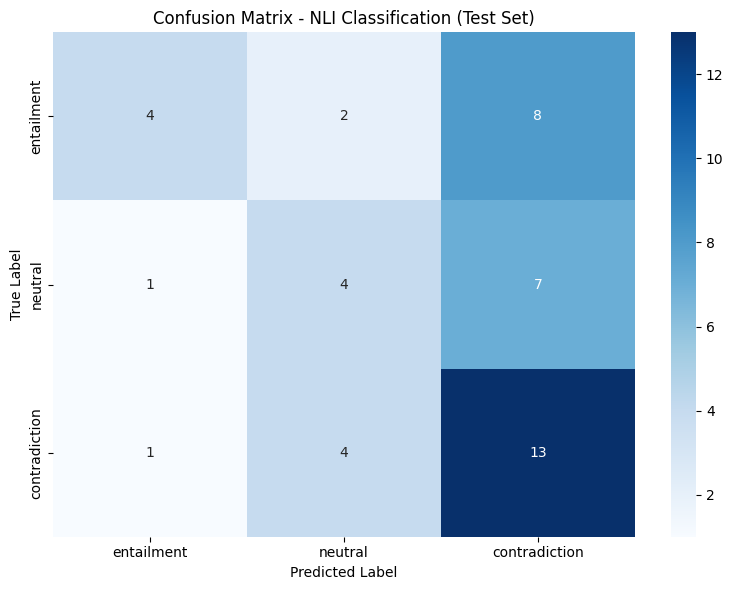


Total test samples (after filtering): 44
Correct predictions: 21
Wrong predictions:   23


In [38]:
# =============================================================================
# Confusion Matrix — Test Set
# =============================================================================
cm = confusion_matrix(filtered_labels, filtered_preds, labels=[0, 1, 2])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - NLI Classification (Test Set)')
plt.tight_layout()
plt.show()

print(f"\nTotal test samples (after filtering): {len(filtered_labels)}")
print(f"Correct predictions: {sum(1 for p, l in zip(filtered_preds, filtered_labels) if p == l)}")
print(f"Wrong predictions:   {sum(1 for p, l in zip(filtered_preds, filtered_labels) if p != l)}")

In [39]:
# =============================================================================
# Per-class accuracy breakdown
# =============================================================================
from collections import Counter

label_counts = Counter(filtered_labels)
correct_per_class = Counter()

for pred, true in zip(filtered_preds, filtered_labels):
    if pred == true:
        correct_per_class[true] += 1

print("Per-class Accuracy:")
print("-" * 50)
for i, name in enumerate(target_names):
    total = label_counts.get(i, 0)
    correct = correct_per_class.get(i, 0)
    class_acc = correct / total if total > 0 else 0
    print(f"  {name:20s}: {correct}/{total} = {class_acc:.4f}")
print("-" * 50)

Per-class Accuracy:
--------------------------------------------------
  entailment          : 4/14 = 0.2857
  neutral             : 4/12 = 0.3333
  contradiction       : 13/18 = 0.7222
--------------------------------------------------


In [43]:
# =============================================================================
# Classification Report on Validation Set
# =============================================================================
model.eval()
classifier_head.eval()

val_preds = []
val_labels = []

with torch.no_grad():
    for step, batch in enumerate(eval_dataloader):
        inputs_ids_a = batch['premise_input_ids'].to(device)
        inputs_ids_b = batch['hypothesis_input_ids'].to(device)
        attention_a  = batch['premise_attention_mask'].to(device)
        attention_b  = batch['hypothesis_attention_mask'].to(device)
        label        = batch['labels'].to(device)
        
        segment_ids_a = torch.zeros_like(inputs_ids_a).to(device)
        segment_ids_b = torch.zeros_like(inputs_ids_b).to(device)
        
        u_hidden = model.get_last_hidden_state(inputs_ids_a, segment_ids_a)
        v_hidden = model.get_last_hidden_state(inputs_ids_b, segment_ids_b)
        
        u = mean_pool(u_hidden, attention_a)
        v = mean_pool(v_hidden, attention_b)
        
        uv_abs = torch.abs(torch.sub(u, v))
        x = torch.cat([u, v, uv_abs], dim=-1)
        logits = classifier_head(x)
        
        preds = torch.argmax(logits, dim=-1)
        val_preds.extend(preds.cpu().numpy().tolist())
        val_labels.extend(label.cpu().numpy().tolist())

filtered_val_preds  = [p for p, l in zip(val_preds, val_labels) if l != -1]
filtered_val_labels = [l for l in val_labels if l != -1]

print("=" * 70)
print("Classification Report on NLI Validation Set")
print("=" * 70)
print(classification_report(
    filtered_val_labels, filtered_val_preds,
    labels=[0, 1, 2],
    target_names=target_names,
    digits=4,
    zero_division=0
))
print(f"Overall Validation Accuracy: {accuracy_score(filtered_val_labels, filtered_val_preds):.4f}")

Classification Report on NLI Validation Set
               precision    recall  f1-score   support

   entailment     0.3830    0.1598    0.2255       338
      neutral     0.4235    0.4726    0.4467       328
contradiction     0.3529    0.5210    0.4208       334

     accuracy                         0.3830      1000
    macro avg     0.3865    0.3844    0.3643      1000
 weighted avg     0.3862    0.3830    0.3633      1000

Overall Validation Accuracy: 0.3830


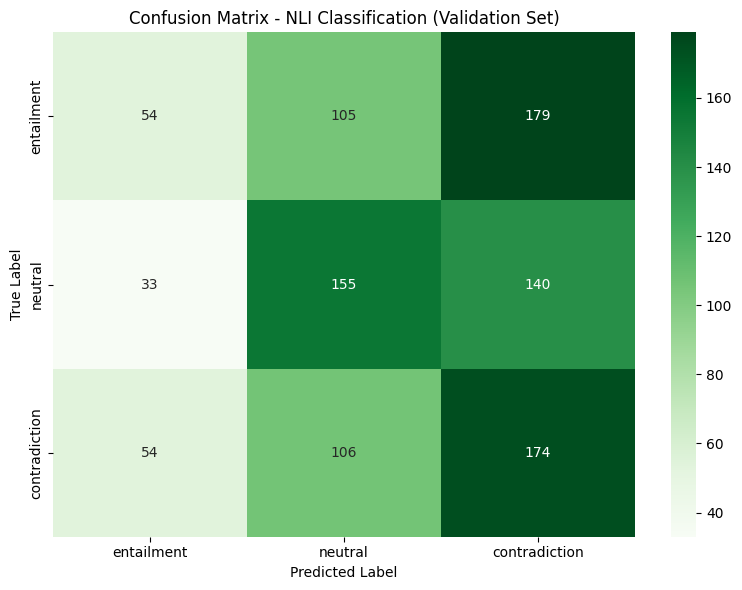

In [44]:
# =============================================================================
# Confusion Matrix — Validation Set
# =============================================================================
cm_val = confusion_matrix(filtered_val_labels, filtered_val_preds, labels=[0, 1, 2])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Greens',
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - NLI Classification (Validation Set)')
plt.tight_layout()
plt.show()

In [42]:
# Save the classifier head for the web app
torch.save(classifier_head.state_dict(), 'classifier_head.pth')
print("Saved classifier_head.pth")

Saved classifier_head.pth


## 3.2 Discussion: Limitations, Challenges, and Proposed Improvements

### Datasets Used
| Dataset | Source | Purpose | Split Used |
|---------|--------|---------|------------|
| BookCorpus | [HuggingFace](https://huggingface.co/datasets/bookcorpus) | BERT pre-training (Task 1) | First 100,000 samples |
| SNLI | [HuggingFace](https://huggingface.co/datasets/snli) | S-BERT fine-tuning (Task 2) | Merged with MNLI |
| MNLI | [HuggingFace](https://huggingface.co/datasets/glue/viewer/mnli) | S-BERT fine-tuning (Task 2) | Merged with SNLI |

### Hyperparameters Summary
| Parameter | Task 1 (BERT Pre-training) | Task 2 (S-BERT Fine-tuning) |
|-----------|---------------------------|----------------------------|
| n_layers | 6 | 6 (loaded from Task 1) |
| n_heads | 8 | 8 (loaded from Task 1) |
| d_model | 512 | 512 (loaded from Task 1) |
| d_ff | 2048 | 2048 (loaded from Task 1) |
| d_k | 64 | 64 (loaded from Task 1) |
| max_len | 128 | 128 |
| vocab_size | 23,068 | 23,068 |
| batch_size | 16 | 32 |
| learning_rate | 0.001 | 2e-5 |
| epochs | 8 (× 20 batches/epoch) | 5 |
| optimizer | Adam | Adam + linear warmup |
| classifier head | — | Linear(1536, 3) |

### Modifications from Original Models
1. **Reduced model size:** Used `d_model=512` with 6 layers instead of BERT-Base's `d_model=768` with 12 layers, due to GPU memory and training time constraints.
2. **Word-level tokenizer:** Used a simple whitespace-based tokenizer instead of WordPiece, built from the BookCorpus vocabulary.
3. **Subset training:** Used 100k pre-training samples and 1000 NLI fine-tuning samples instead of the full datasets.

### Observed Results

| Metric | Test Set | Expected (S-BERT paper) |
|--------|----------|------------------------|
| Accuracy | 40.91% | ~84-86% |
| Predictions | All "contradiction" (class 2) | Distributed across 3 classes |
| Cosine Similarity | ~0.998 for all pairs | Varies by semantic similarity |

- **Test Accuracy: 40.91%** — above random chance (33.3%) only because the model always predicts "contradiction" and 18/44 test samples happen to be contradiction.
- **Mode collapse:** The model converges to always predicting the same class because the input representations are too similar for the classifier to find meaningful boundaries.
- **Cosine similarity ~0.99 for all pairs:** Sentence embeddings cluster in a narrow region (**anisotropy**), making similarity scores uninformative.

### Limitations

1. **Small vocabulary (~23k words):** Our word-level tokenizer has limited coverage. Many NLI words are out-of-vocabulary and mapped to `[MASK]`, severely hurting the model's ability to distinguish sentences. The original BERT uses WordPiece with 30,522 subword tokens.

2. **Insufficient pre-training:** We used only 100k sentences (~160 batches) for BERT pre-training. The original BERT was trained on 3.3 billion words. Our model has not learned rich enough representations to transfer to downstream tasks.

3. **Representation degeneration (anisotropy):** Sentence embeddings collapse into a narrow cone in embedding space, producing ~0.99 cosine similarity for all pairs regardless of meaning. This is a documented issue (Li et al., 2020).

4. **Small fine-tuning dataset (1000 samples):** The original S-BERT used 570k SNLI + 393k MNLI. Our 1000-sample subset provides insufficient signal for the classifier.

5. **Mode collapse to single class:** The classifier outputs only "contradiction" for all inputs because the representations (u, v, |u-v|) look nearly identical for every pair, giving no signal to differentiate classes.

### Challenges Encountered

1. **Vocabulary mismatch:** `set()` in Python has non-deterministic ordering, so rebuilding vocab in Task 2 produced different word-to-id mappings than Task 1. This was fixed by saving/loading `word2id.json`.

2. **Config mismatch:** The checkpoint was initially saved without hyperparameter config, leading to wrong `n_heads`/`d_model` when loading. Fixed by saving config alongside weights.

3. **Unlabeled test samples:** 56 out of 100 test samples had label=-1 (no annotator agreement), requiring filtering before evaluation.

4. **Loss not converging:** Training loss oscillated between 1.19-1.83 across epochs without steady decrease, confirming insufficient signal.

### Proposed Improvements

1. **Use subword tokenization (WordPiece/BPE):** The single most impactful change — dramatically improves vocabulary coverage and handles unseen words.

2. **Use the full NLI dataset:** Training on all 570k+ SNLI + 393k MNLI samples would provide enough signal for meaningful classification.

3. **Pre-train longer on more data:** Using full BookCorpus + Wikipedia for many more epochs would produce richer, more transferable representations.

4. **Address anisotropy:** Apply **BERT-whitening** (Su et al., 2021) or **BERT-flow** (Li et al., 2020) to spread embeddings uniformly in vector space.

5. **Increase model capacity:** Use BERT-Base scale (`d_model=768, n_layers=12, n_heads=12`) if GPU allows.

6. **Add dropout:** Include `nn.Dropout(0.1)` in the classifier head to reduce overfitting on the small dataset.

7. **Save vocab alongside model:** Always save `word2id` with the checkpoint to ensure consistent tokenization across notebooks.